In [1]:
%matplotlib inline
# %matplotlib notebook
# %matplotlib ipympl
# %matplotlib widget
#      widget, if installed and working, gives nicer inline plots
# %matplotlib nbagg
# Fix failing variable completion:
# %config Completer.use_jedi = False

# First, Simplest Usecase

Let's optimize a simple ellipsoid function, $\sum_{i=1}^n 1000^{\frac{i-1}{n-1}}x_i^2$, whose Hessian has a condition number of $10^6$:

In [2]:
# pip install cma  # outcomment in case the cma module is not installed
import cma

fun = cma.ff.elli  # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
x0 = 4 * [2]  # initial solution
sigma0 = 1    # initial standard deviation to sample new solutions

xopt, es = cma.fmin2(fun, x0, sigma0)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=812526, Tue Jan  3 19:53:56 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.083603683127986e+06 1.0e+00 1.14e+00  1e+00  1e+00 0:00.0
    2     16 3.344987125233561e+05 1.6e+00 1.30e+00  1e+00  2e+00 0:00.0
    3     24 3.279183367164091e+05 1.7e+00 1.39e+00  1e+00  2e+00 0:00.0
  100    800 6.456498230731349e-05 9.4e+02 8.50e-03  1e-05  9e-03 0:00.1
  178   1424 1.384576412350625e-14 1.2e+03 1.67e-06  7e-11  8e-08 0:00.3
termination on tolfun=1e-11 (Tue Jan  3 19:53:56 2023)
final/bestever f-value = 6.733699e-15 6.733699e-15
incumbent solution: [-2.3194871349553344e-08, 2.982492598126481e-09, 6.339442297700981e-10, -3.587921686298016e-11]
std deviation: [8.19890644438088e-08, 5.8809651398826955e-09, 5.990776215810285e-10, 6.743811853186867e-11]


The return values are
- `xopt`, generally the best evaluated solution and
- `es`, the `cma.CMAEvolutionStrategy` class instance used to run the optimization.

The latter contains all available information about the run and the more complete return value under `es.result`.

In [3]:
es.result

CMAEvolutionStrategyResult(xbest=array([-2.31948713e-08,  2.98249260e-09,  6.33944230e-10, -3.58792169e-11]), fbest=6.733699333999042e-15, evals_best=1425, evaluations=1425, iterations=178, xfavorite=array([-2.31948713e-08,  2.98249260e-09,  6.33944230e-10, -3.58792169e-11]), stds=array([8.19890644e-08, 5.88096514e-09, 5.99077622e-10, 6.74381185e-11]), stop={'tolfun': 1e-11})

In [4]:
es.result_pretty()  # shows some pretty information and returns es.result

termination on tolfun=1e-11
final/bestever f-value = 6.733699e-15 6.733699e-15
incumbent solution: [-2.3194871349553344e-08, 2.982492598126481e-09, 6.339442297700981e-10, -3.587921686298016e-11]
std deviation: [8.19890644438088e-08, 5.8809651398826955e-09, 5.990776215810285e-10, 6.743811853186867e-11]


CMAEvolutionStrategyResult(xbest=array([-2.31948713e-08,  2.98249260e-09,  6.33944230e-10, -3.58792169e-11]), fbest=6.733699333999042e-15, evals_best=1425, evaluations=1425, iterations=178, xfavorite=array([-2.31948713e-08,  2.98249260e-09,  6.33944230e-10, -3.58792169e-11]), stds=array([8.19890644e-08, 5.88096514e-09, 5.99077622e-10, 6.74381185e-11]), stop={'tolfun': 1e-11})

# Options and Plotting
Let's plot some data from the optimization. The above call to `cma.fmin2` has (by default) written data to the default output folder `outcmaes`. These data will be overwritten each time the function is called again. To prevent this, we could set/change the output folder with the `verb_filenameprefix` option. An effective way to find out this kind of behavior is to query the [`CMAOptions`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAOptions.html) with a search string and read the comments in the return "value".

In [5]:
cma.CMAOptions('file')

{'signals_filename': 'cma_signals.in  # read versatile options from this file (use `None` or `""` for no file) which contains a single options dict, e.g. ``{"timeout": 0}`` to stop, string-values are evaluated, e.g. "np.inf" is valid',
 'verb_append': '0  # initial evaluation counter, if append, do not overwrite output files',
 'verb_filenameprefix': 'outcmaes/  # output path (folder) and filenames prefix',
 'verb_log': '1  #v verbosity: write data to files every verb_log iteration, writing can be time critical on fast to evaluate functions'}

Plotting is as simple as

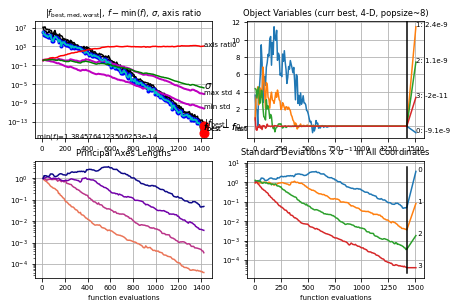

In [6]:
es.plot();  # cma.plot() does the same, as we just plot the data from the default output folder

A description of the output is given in the caption of Figure 3 in [Hansen et al (2015): Evolution Strategies](https://hal.inria.fr/hal-01155533/file/es-overview-2015.pdf#page=17).

# Options and Bound Constraints
We can add a boundary condition on any variable. We can find out how to do this, as mentioned above, by investigating the available boundary related options:

In [7]:
cma.CMAOptions('bound')  # returns options that contain "bound"

{'BoundaryHandler': 'BoundTransform  # or BoundPenalty, unused when ``bounds in (None, [None, None])``',
 'bounds': '[None, None]  # lower (=bounds[0]) and upper domain boundaries, each a scalar or a list/vector'}

Let's bound the second variable from below to values $\ge1$ using the `'bounds'` option. In this case, we must also take care that the initial solution is within the given bounds (it is, in our case). `'bounds'` is a list of two values, `[lower_bounds, upper_bounds]`, where `lower_bounds` and `upper_bounds` can be a scalar that applies to all variables or a list. If the list is shorter than the initial solution, the last value is applied to the remaining dimensions.

In [8]:
xopt_b, es_b = cma.fmin2(fun, x0, sigma0, {'bounds': [[None, 1, None], None]})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=817432, Tue Jan  3 19:53:59 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.286833283633317e+05 1.0e+00 8.97e-01  9e-01  9e-01 0:00.0
    2     16 3.387695404594926e+04 1.3e+00 1.03e+00  1e+00  1e+00 0:00.0
    3     24 4.494818591857136e+04 1.6e+00 1.03e+00  1e+00  1e+00 0:00.0
  100    800 1.000000110325119e+02 1.6e+03 1.96e-03  1e-06  2e-03 0:00.2
  164   1312 9.999999999999997e+01 9.3e+02 7.67e-07  6e-11  5e-08 0:00.4
termination on tolfun=1e-11 (Tue Jan  3 19:54:00 2023)
final/bestever f-value = 1.000000e+02 1.000000e+02
incumbent solution: [3.919939463589729e-08, 1.0, -5.003484798310171e-10, 4.10947461473138e-11]
std deviation: [5.2594964736311716e-08, 2.93575965599097e-09, 3.6496457976118405e-10, 5.901027179566108e-11]


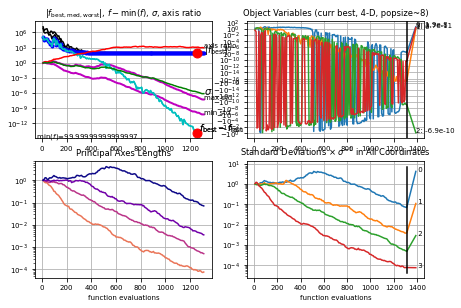

In [9]:
es.plot(xsemilog=True, x_opt=[0, 1] + (len(x0) - 2) * [0]);

### Rescaling of the Objective
In a practical application, the encoding of variables is often essential to turn a _very_ difficult problem into less difficult one, see also [here](https://cma-es.github.io/cmaes_sourcecode_page.html#practical). The simplest encoding is a rescaling, which can easily be done via the [`cma.ScaleCoordinates`](https://cma-es.github.io/apidocs-pycma/cma.fitness_transformations.ScaleCoordinates.html) class. Again, the [`CMAOptions`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAOptions.html) give the hint where to look.

In [10]:
cma.CMAOptions('scale')

{'CMA_stds': 'None  # multipliers for sigma0 in each coordinate, not represented in C, better use `cma.ScaleCoordinates` instead',
 'scaling_of_variables': 'None  # deprecated, rather use fitness_transformations.ScaleCoordinates instead (or possibly CMA_stds). Scale for each variable in that effective_sigma0 = sigma0*scaling. Internally the variables are divided by scaling_of_variables and sigma is unchanged, default is `np.ones(N)`'}

We rescale the ellipsoid function to its most benign form. In dimension 4, this saves only about 30% of the necessary iterations.

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=816247, Tue Jan  3 19:54:02 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.763976745680367e+00 1.0e+00 8.72e-01  7e-01  9e-01 0:00.0
    2     16 7.826713648441617e+00 1.3e+00 8.33e-01  7e-01  8e-01 0:00.0
    3     24 2.622291528350178e+00 1.4e+00 9.78e-01  9e-01  1e+00 0:00.0
  100    800 4.594910967150106e-12 1.6e+00 7.60e-05  1e-06  2e-06 0:00.1
  124    992 3.125364210615306e-15 1.5e+00 8.18e-06  5e-08  7e-08 0:00.2
termination on tolfun=1e-11 (Tue Jan  3 19:54:02 2023)
final/bestever f-value = 3.435465e-15 3.125364e-15
incumbent solution: [6.198403011469838e-09, 3.502662601587346e-08, 3.580838788171748e-08, 2.9798321389633534e-08]
std deviation: [5.573921300637813e-08, 6.837461316850388e-08, 6.303570500507975e-08, 4.9403527604350234e-08]


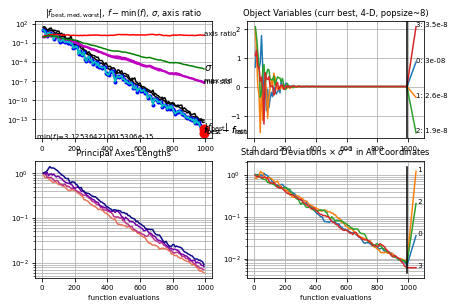

In [11]:
fun2 = cma.ScaleCoordinates(fun, [1000**(-i / 3) for i in range(4)])
xopt2, es2 = cma.fmin2(fun2, x0, sigma0)
cma.plot();


On the 40-dimension ellipsoid function, the saving is _much_ more substantial, namely a factor of about 6 to 7:

In [12]:
xopt40, es40 = cma.fmin2(fun, 40 * [2], sigma0, {'verbose':-9})
xopt0, es0 = cma.fmin2(cma.ScaleCoordinates(fun,
                                            [1000**(-i / 39) for i in range(40)]),
                       40 * [2], sigma0, {'verbose':-9})

In [13]:
es40.result.fbest, es0.result.fbest, es40.result.evals_best / es0.result.evals_best

(3.0047502830548e-14, 1.5304762306953928e-14, 6.721911209477932)

Without covariance matrix adaptation, the saving would be a factor of about 10,000 which can be inferred from Figure 10 in [Hansen and Ostermeier (2001)](http://www.cmap.polytechnique.fr/~nikolaus.hansen/publications.html#hansenaost2001).

### Advanced options settings
#### Setting the step-size adaptation
Apart from the default cumulative step-size adaptation there is a second competitive way to adapt the step-size, namely two-point step-size adaptation, TPA.

In [14]:
cma.CMAOptions('sigma')

{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'CMA_dampsvec_fac': 'np.Inf  # tentative and subject to changes, 0.5 would be a "default" damping for sigma vector update',
 'CMA_dampsvec_fade': '0.1  # tentative fading out parameter for sigma vector update',
 'CMA_stds': 'None  # multipliers for sigma0 in each coordinate, not represented in C, better use `cma.ScaleCoordinates` instead',
 'CSA_squared': 'False  #v use squared length for sigma-adaptation ',
 'scaling_of_variables': 'None  # deprecated, rather use fitness_transformations.ScaleCoordinates instead (or possibly CMA_stds). Scale for each variable in that effective_sigma0 = sigma0*scaling. Internally the variables are divided by scaling_of_variables and sigma is unchanged, default is `np.ones(N)`',
 'tolupsigma': '1e20  #v sigma/sigma0 > tolupsigma * max(eivenvals(C)**0.5) indicates "creeping behavior" with usually minor improvements'}

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=841496, Tue Jan  3 19:54:16 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.298952560102188e+06 1.0e+00 1.15e+00  1e+00  1e+00 0:00.0
    2     16 3.679865876054685e+05 1.3e+00 1.38e+00  1e+00  2e+00 0:00.0
    3     24 7.071508115679095e+03 1.5e+00 1.72e+00  2e+00  2e+00 0:00.0
  100    800 1.131473463979913e-03 1.0e+03 1.58e-02  3e-05  3e-02 0:00.1
  177   1416 1.418335426175350e-13 1.2e+03 1.64e-06  2e-10  2e-07 0:00.2
termination on tolfun=1e-11 (Tue Jan  3 19:54:16 2023)
final/bestever f-value = 2.443270e-14 2.443270e-14
incumbent solution: [-3.13495206229351e-08, 6.092122101845577e-09, -1.2033033220726967e-09, -7.251981895792659e-11]
std deviation: [2.4744259873018306e-07, 2.0176167875956206e-08, 2.175842178098232e-09, 2.1925351076174428e-10]


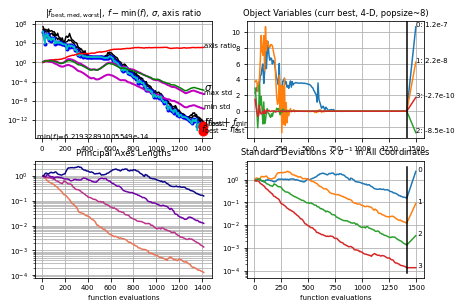

In [15]:
xopt, es = cma.fmin2(fun, x0, sigma0,
                     {'AdaptSigma': cma.sigma_adaptation.CMAAdaptSigmaTPA})
cma.plot();

Without step-size adaptation, the final stage of the optimization takes about 3 to 4 times longer (and the effect would become more pronounced in higher dimension):

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=876251, Tue Jan  3 19:54:18 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.799816880319933e+05 1.0e+00 1.00e+00  1e+00  1e+00 0:00.0
    2     16 3.735580402292251e+04 1.2e+00 1.00e+00  9e-01  1e+00 0:00.0
    3     24 9.623272545951477e+04 1.3e+00 1.00e+00  8e-01  1e+00 0:00.0
  100    800 7.168021054510803e-01 1.3e+03 1.00e+00  7e-04  8e-01 0:00.1
  200   1600 2.220999312991630e-05 9.5e+02 1.00e+00  7e-06  7e-03 0:00.3
  300   2400 7.647764388331268e-10 1.1e+03 1.00e+00  6e-08  6e-05 0:00.4
  400   3200 4.710961799488151e-13 9.4e+02 1.00e+00  8e-10  7e-07 0:00.5
  406   3248 2.602900639621161e-13 9.8e+02 1.00e+00  6e-10  5e-07 0:00.5
termination on tolfun=1e-11 (Tue Jan  3 19:54:19 2023)
final/bestever f-value = 1.012187e-13 1.012187e-13
incumbent solution: [1.5377059061328423e-07, 1.4416780195990509e-08, 2.211550361113316e-09, -8.876621697774111e-11]
std deviation: [5.22407281918988

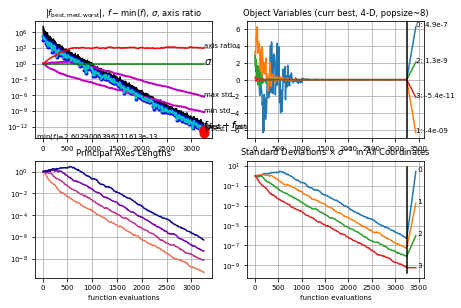

In [16]:
xopt, es = cma.fmin2(fun, x0, sigma0, {'AdaptSigma': False})
cma.plot();

#### Setting different learning rates
A more research related option is the manual setting of learning rates. We can find the relevant options for the covariance matrix update like

In [17]:
cma.CMAOptions('covar')

{'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_on': '1  # multiplier for all covariance matrix updates',
 'CMA_rankmu': '1.0  # multiplier for rank-mu update learning rate of covariance matrix',
 'CMA_rankone': '1.0  # multiplier for rank-one update learning rate of covariance matrix',
 'tolconditioncov': '1e14  #v stop if the condition of the covariance matrix is above `tolconditioncov`'}

If we want to run CMA-ES only with rank-$\mu$ update, we set the learning rate for the rank-one update to zero. Then, to get a solution of the same quality on the 4-dimensional ellipsoid function, it takes on average about 15% more iterations.

In [18]:
xopt, es = cma.fmin2(fun, x0, sigma0, {'CMA_rankone': 0})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=858031, Tue Jan  3 19:54:21 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 7.433392480710708e+05 1.0e+00 1.13e+00  1e+00  1e+00 0:00.0
    2     16 1.723169278718654e+04 1.2e+00 1.14e+00  1e+00  1e+00 0:00.0
    3     24 9.740748641530723e+03 1.4e+00 1.01e+00  9e-01  1e+00 0:00.0
  100    800 3.959634357363526e-01 4.4e+02 6.76e-02  6e-04  2e-01 0:00.2
  200   1600 4.849551157840750e-12 1.2e+03 1.77e-06  1e-09  1e-06 0:00.4
  221   1768 2.788578922826717e-15 1.1e+03 2.33e-07  1e-10  1e-07 0:00.4
termination on tolfun=1e-11 (Tue Jan  3 19:54:22 2023)
final/bestever f-value = 7.538313e-15 2.788579e-15
incumbent solution: [-5.829888163336979e-08, 2.114286070767098e-09, -6.864970528778626e-11, 6.03771921056116e-11]
std deviation: [1.1173825538410156e-07, 1.4268860068974581e-08, 1.2120645266540523e-09, 1.0489368075307663e-10]


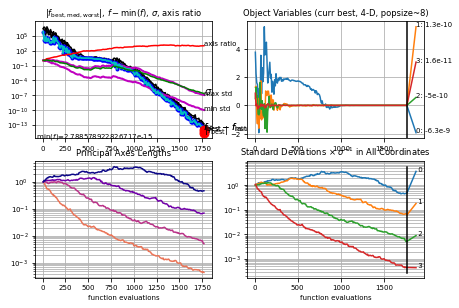

In [19]:
cma.plot();

## See Also

Other [`notebooks and recipes`](https://github.com/CMA-ES/pycma/tree/master/notebooks), as this one, can be found at [https://github.com/CMA-ES/pycma/tree/master/notebooks](https://github.com/CMA-ES/pycma/tree/master/notebooks)

More `notebook-recipes` to come...